In [189]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics.cluster import normalized_mutual_info_score as NMI
import random

In [190]:
df = pd.read_csv('lung-cancer.csv', header=None)
output = open('Q1_output.txt', 'w')
print(df.shape)
for index in range(1, df.shape[1]):
    df.iloc[df.iloc[:, index] == '?', index] = df.iloc[:, index].mode()[0]
    df.iloc[:, index] = pd.to_numeric(df.iloc[:, index])

(32, 57)


In [191]:
X = df.iloc[:, 1:]
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
print("The dimensions of the dataframe before performing PCA preserving 95% variance : ", X_scaled.shape, file = output)
pca = PCA(n_components = 0.95)
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)
print("The dimensions of the dataframe after performing PCA preserving 95% variance : ", X_pca.shape, file = output)
print("\nThe variance obtained for each feature selected by PCA in sorted order :\n", pca.explained_variance_ratio_ * 100, file = output)
print("\nFinal variance obtained after including all the features selected by PCA : ", sum(pca.explained_variance_ratio_ * 100), file = output)

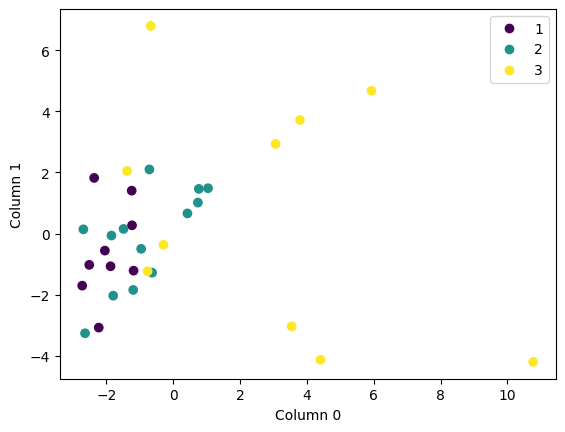

In [192]:
actual_val = df.iloc[:, 0]
plot = plt.scatter(X_pca[:,0], X_pca[:,1], c=actual_val)
plt.legend(handles=plot.legend_elements()[0], labels=list(actual_val.unique()))
plt.xlabel('Column 0')
plt.ylabel('Column 1')
plt.savefig('Q1_plot_1.png')

In [193]:
def clustering(X_pca, centroids, k):
    clusters = {}
    for i in range(k):
        clusters[i] = []
    for data in X_pca:
        dist = []
        for j in range(k):
            dist.append(np.linalg.norm(data - centroids[j]))
        clusters[dist.index(min(dist))].append(data)
    for i in range(k):
        centroids[i] = np.average(clusters[i], axis=0)
    return clusters, centroids

def cmp(new_dict, prev_dict):
    for i in range(len(new_dict)):
        if len(new_dict[i]) != len(prev_dict[i]):
            return False
        for j in range(len(new_dict[i])):
            if (new_dict[i][j] != prev_dict[i][j]).any():
                return False
    return True

def KMeans(X_pca, actual_val, k):
    centroids = {}
    clusters = {}
    X_rand_centroid = random.sample(range(X_pca.shape[0]),k)
    for i in range(k):
        clusters[i] = []
        centroids[i] = X_pca[X_rand_centroid[i],:]
    for data in X_pca:
        dist = []
        for j in range(k):
            dist.append(np.linalg.norm(data - centroids[j]))
        clusters[dist.index(min(dist))].append(data)
    for i in range(1000):
        new_clusters, new_centroids = clustering(X_pca, centroids, k)
        if cmp(new_clusters, clusters) or cmp(new_centroids, centroids):
            break
        else:
            clusters = new_clusters
            centroids = new_centroids
    pred_val = []
    counter = 0
    for cluster in clusters.values():
        cluster_val = []
        for i in range(len(cluster)):
            cluster_val.append(actual_val[counter])
            counter+=1
        cluster_rep = max(set(cluster_val), key=cluster_val.count)
        for i in range(len(cluster_val)):
            pred_val.append(cluster_rep)
    return pred_val


In [194]:
k_list = []
NMI_list = []
print("\nThe list of values of NMI obtained for each k :", file = output)
for k in range(2,9):
    pred_val = KMeans(X_pca, actual_val, k)
    NMI_val = NMI(list(actual_val),list(pred_val))
    k_list.append(k)
    NMI_list.append(NMI_val)
    print(k, " : ", NMI_val, file = output)
print("\nThe value of K for which maximum value of NMI is obtained is : ", k_list[NMI_list.index(max(NMI_list))], file = output)

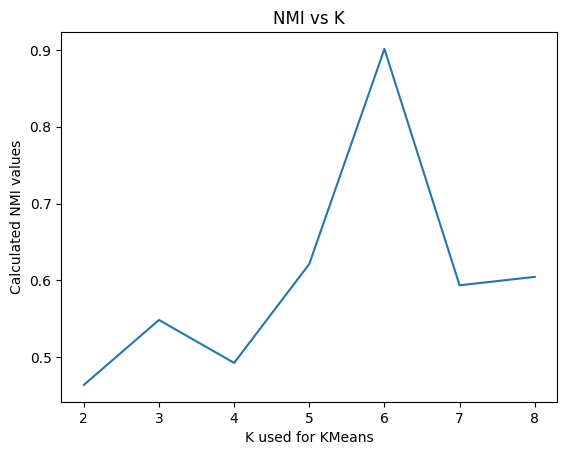

In [195]:
plt.plot(k_list, NMI_list)
plt.xlabel('K used for KMeans')
plt.ylabel('Calculated NMI values')
plt.title('NMI vs K')
plt.savefig('Q1_plot_2.png')

In [196]:
output.close()